In [4]:
import numpy as np
import pandas as pd
import sys, os, glob
import imp
import seaborn as sns
sys.path.append('./src/')
import doc_utils
import defines
import my_bert
import feature_utils
import common_utils

In [5]:
dir_name="recalc_tfidf"

## Give a try to AlephBERT

In [2]:
from transformers import BertModel, BertTokenizerFast


In [3]:
alephbert_tokenizer = BertTokenizerFast.from_pretrained('onlplab/alephbert-base')
alephbert = BertModel.from_pretrained('onlplab/alephbert-base', return_dict=False)

# # if not finetuning - disable dropout
# alephbert.eval()

Some weights of BertModel were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
sent_db = common_utils.concat_dbs(dir_name,"sent_db",['text','is_nar'])
sent_db

,doc_idx,sent_idx,text,is_nar
0,1,0,אז היום אנחנו נפגשים פה ב18 אבל שבוע הבא בחמישי,0.000000
1,1,1,כן,0.000000
2,1,2,אוקיי מה שלומך?,0.000000
3,1,3,ברוך השם,0.000000
4,1,4,מחר יש לכם יום טיול,0.000000
...,...,...,...,...
36319,80,486,שאני מרגיש בהם לא נוח,0.000000
36320,80,487,אז כאילו למה למה אני מתגעגע,0.000000
36321,80,488,או למה אני למה אני רוצה,0.000000
36322,80,489,והצלחת לענות לעצמך?,0.000000


In [41]:
imp.reload(my_bert)
train_text, train_labels, val_text, test_text, val_labels, test_labels, test_docs = my_bert.split_train_val_test_per_doc(sent_db)
tokens_train,tokens_val,tokens_test = my_bert.get_train_val_test_tokens(alephbert_tokenizer,train_text,val_text,test_text)
tensor_map = my_bert.covert_token2tensor(tokens_train,train_labels,tokens_val,val_labels,tokens_test,test_labels)
train_dataloader,val_dataloader = my_bert.get_data_loader(tensor_map)
wrapped_model = my_bert.wrap_pretained_model(alephbert)
optimizer = my_bert.get_optimizer(wrapped_model)
cross_entropy = my_bert.get_cross_entropy(train_labels)

Class Weights: [0.68633507 1.84166905]


In [43]:
test_docs

{4, 12, 13, 14, 18, 27, 28, 29, 69, 70, 72, 78}

In [51]:
test_docs_for_json = [i.item() for i in test_docs]

In [52]:
import json
json_path = os.path.join(os.getcwd(),defines.PATH_TO_DFS,dir_name,"test_doc_indices.json")
with open(json_path, 'w') as fp:
    json.dump(test_docs_for_json,fp)

In [30]:
imp.reload(my_bert)
model_name = "alephbert"
my_bert.train_validate(model_name,wrapped_model,optimizer,train_dataloader,val_dataloader,cross_entropy)


 Epoch 1 / 10
  Batch    50  of    806.
  Batch   100  of    806.
  Batch   150  of    806.
  Batch   200  of    806.
  Batch   250  of    806.
  Batch   300  of    806.
  Batch   350  of    806.
  Batch   400  of    806.
  Batch   450  of    806.
  Batch   500  of    806.
  Batch   550  of    806.
  Batch   600  of    806.
  Batch   650  of    806.
  Batch   700  of    806.
  Batch   750  of    806.
  Batch   800  of    806.

Evaluating...
Saving best model alephbert

Training Loss: 0.593
Validation Loss: 0.597

 Epoch 2 / 10
  Batch    50  of    806.
  Batch   100  of    806.
  Batch   150  of    806.
  Batch   200  of    806.
  Batch   250  of    806.
  Batch   300  of    806.
  Batch   350  of    806.
  Batch   400  of    806.
  Batch   450  of    806.
  Batch   500  of    806.
  Batch   550  of    806.
  Batch   600  of    806.
  Batch   650  of    806.
  Batch   700  of    806.
  Batch   750  of    806.
  Batch   800  of    806.

Evaluating...

Training Loss: 0.517
Validation Lo

### Load Saved Model & get prediction for test

In [ ]:
# impb.reload(my_bert)
imp.reload(feature_utils)
saved_model = my_bert.load_saved_bert_model(wrapped_model,model_name)
preds = my_bert.get_prediction(saved_model,tensor_map['test'])

              precision    recall  f1-score   support

           0       0.82      0.68      0.74      4029
           1       0.53      0.70      0.60      2074

    accuracy                           0.69      6103
   macro avg       0.67      0.69      0.67      6103
weighted avg       0.72      0.69      0.69      6103



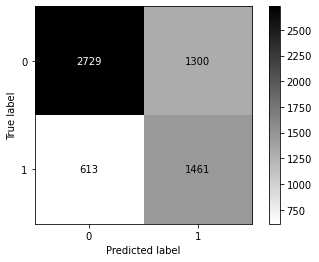

In [33]:
feature_utils.get_prediction_report(tensor_map['test']['y'],preds,[0,1])

In [36]:
tensor_map['test']

{'seq': tensor([[    2,  1998, 30266,  ...,     0,     0,     0],
         [    2,  2656,  1837,  ...,     0,     0,     0],
         [    2,  3232,  1837,  ...,     0,     0,     0],
         ...,
         [    2,  2204,  8604,  ...,     0,     0,     0],
         [    2,  1876,  5573,  ...,     0,     0,     0],
         [    2,  1998,     3,  ...,     0,     0,     0]]),
 'mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'y': tensor([0, 0, 0,  ..., 0, 0, 0])}

In [19]:
test_labels

6009    0.000000
6010    0.000000
6011    0.000000
6012    0.000000
6013    0.000000
          ...   
35576   0.000000
35577   0.000000
35578   0.000000
35579   0.000000
35580   0.000000
Name: is_nar, Length: 5263, dtype: float64

In [ ]:
feature_utils.get_prediction_report(tensor_map['test']['y'],preds,['not_nar','nar'])

## heBERT

In [125]:
from transformers import AutoTokenizer, AutoModel

he_tokenizer = AutoTokenizer.from_pretrained("avichr/heBERT")
he_model = AutoModel.from_pretrained("avichr/heBERT")

Some weights of BertModel were not initialized from the model checkpoint at avichr/heBERT and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [126]:
tokens_train,tokens_val,tokens_test = my_bert.get_train_val_test_tokens(he_tokenizer,train_text,val_text,test_text)
tensor_map = my_bert.covert_token2tensor(tokens_train,train_labels,tokens_val,val_labels,tokens_test,test_labels)
train_dataloader,val_dataloader = my_bert.get_data_loader(tensor_map)
wrapped_model = my_bert.wrap_pretained_model(he_model)
cross_entropy = my_bert.get_cross_entropy(train_labels)

/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2073: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Class Weights: [0.72247065 1.62374372]


/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0. 1.], y=30342   0.000000
30855   1.000000
9518    0.000000
6348    0.000000
17553   0.000000
          ...   
28421   0.000000
13379   0.000000
32525   1.000000
18011   1.000000
16747   0.000000
Name: is_nar, Length: 23265, dtype: float64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [127]:
imp.reload(my_bert)
model_name = "heBERT"
my_bert.train_validate(model_name,wrapped_model,optimizer,train_dataloader,val_dataloader,cross_entropy)


 Epoch 1 / 10
  Batch    50  of    728.
  Batch   100  of    728.
  Batch   150  of    728.
  Batch   200  of    728.
  Batch   250  of    728.
  Batch   300  of    728.
  Batch   350  of    728.
  Batch   400  of    728.
  Batch   450  of    728.
  Batch   500  of    728.
  Batch   550  of    728.
  Batch   600  of    728.
  Batch   650  of    728.
  Batch   700  of    728.

Evaluating...
Saving best model heBERT

Training Loss: 0.691
Validation Loss: 0.691

 Epoch 2 / 10
  Batch    50  of    728.
  Batch   100  of    728.
  Batch   150  of    728.
  Batch   200  of    728.
  Batch   250  of    728.
  Batch   300  of    728.
  Batch   350  of    728.
  Batch   400  of    728.
  Batch   450  of    728.
  Batch   500  of    728.
  Batch   550  of    728.
  Batch   600  of    728.
  Batch   650  of    728.
  Batch   700  of    728.

Evaluating...

Training Loss: 0.691
Validation Loss: 0.691

 Epoch 3 / 10
  Batch    50  of    728.
  Batch   100  of    728.
  Batch   150  of    728.
  Ba

              precision    recall  f1-score   support

           0       0.71      0.71      0.71      3451
           1       0.36      0.36      0.36      1535

    accuracy                           0.60      4986
   macro avg       0.53      0.53      0.53      4986
weighted avg       0.60      0.60      0.60      4986



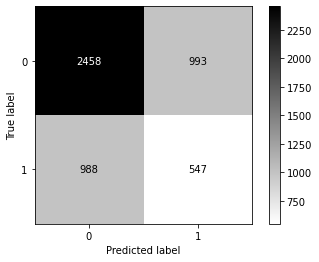

In [131]:
# imp.reload(my_bert)
imp.reload(feature_utils)
saved_model = my_bert.load_saved_bert_model(wrapped_model,model_name)
preds = my_bert.get_prediction(saved_model,tensor_map['test'])
feature_utils.get_prediction_report(tensor_map['test']['y'],preds,labels=[0,1])